# AI-Driven Validator Selection for Secure Proof-of-Stake Blockchain Networks
This notebook demonstrates a modular implementation of a Multi-Agent Reinforcement Learning (MARL) and Explainable AI (XAI) framework for secure validator selection in PoS blockchain networks, as described in the accompanying research paper.

## Notebook Structure
This notebook is organized as follows:

1. **Configuration**: Set up all parameters and paths.
2. **Data Loading & Preprocessing**: Load and align validator data.
3. **Environment Simulation**: Simulate PoS network and validator behaviors.
4. **Agent Definition**: Define base and MARL agents.
5. **Training Loop**: Run MARL training for validator selection.
6. **Evaluation & XAI**: Select top validators, detect malicious agents, and explain decisions.
7. **Export & Visualization**: Save results and visualize trust scores.

In [1]:
# --- Configuration and Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict
import csv
import pickle

# XAI imports
import shap
import lime.lime_tabular

# Set random seed for reproducibility
np.random.seed(42)

@dataclass
class Config:
    dataset_path: str = r"./data/ethereum/validators_mvp.csv"
    log_dir: str = "./logs"
    checkpoint_dir: str = "./checkpoints"
    num_validators: int = 200
    num_epochs: int = 10
    action_space: int = 3  # 0=propose, 1=attest, 2=abstain
    learning_rate: float = 0.1
    gamma: float = 0.95
    epsilon_start: float = 1.0
    epsilon_decay: float = 0.97
    epsilon_min: float = 0.1
    initial_trust: float = 0.5
    trust_decay: float = 0.01
    trust_reward_weight: float = 0.7
    trust_penalty_weight: float = 0.3

In [2]:
# --- Data Loading & Preprocessing ---

REQUIRED_COLUMNS = [
    "validator_index", "slashed", "effective_balance_gwei",
    "attestations_total", "att_missed_total",
    "proposals_total", "prop_missed_total"
 ]

DERIVED_COLUMNS = ["stake", "uptime", "missed_att", "missed_prop"]

def load_and_align_dataset(dataset_path):
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset not found at {dataset_path}")
    df = pd.read_csv(dataset_path) if dataset_path.endswith('.csv') else pd.read_json(dataset_path)
    # Ensure required columns
    for col in REQUIRED_COLUMNS:
        if col not in df.columns:
            df[col] = np.nan
    # Sanitize numeric columns
    for col in ["effective_balance_gwei","attestations_total","att_missed_total","proposals_total","prop_missed_total"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    # Fill NaNs
    df["slashed"] = df.get("slashed", False).fillna(False).astype(bool)
    df["attestations_total"] = df["attestations_total"].fillna(0)
    df["att_missed_total"] = df["att_missed_total"].fillna(0)
    df["proposals_total"] = df["proposals_total"].fillna(0)
    df["prop_missed_total"] = df["prop_missed_total"].fillna(0)
    df["effective_balance_gwei"] = df["effective_balance_gwei"].fillna(0)
    # Feature engineering
    df["stake"] = df["effective_balance_gwei"] / df["effective_balance_gwei"].max()
    df["uptime"] = 1.0 - (df["att_missed_total"] / (df["attestations_total"] + 1e-6))
    df["missed_att"] = df["att_missed_total"]
    df["missed_prop"] = df["prop_missed_total"]
    return df

config = Config()
df = load_and_align_dataset(config.dataset_path)
df.head()

,validator_index,pubkey,status,effective_balance_gwei,slashed,activation_epoch,exit_epoch,withdrawal_credentials,attestations_total,att_missed_total,proposals_total,prop_missed_total,inclusion_delay_avg,rewards_sum_gwei,trust_v0,stake,uptime,missed_att,missed_prop
0,12345,0x80773a007f9e496a196b8f28fae04ddaa72fa65c0f8a...,active_online,32000000000,False,0,9223372036854775807,0x010000000000000000000000ddc6ed6e6a9c1e55c87b...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.015625,1.0,0.0,0.0
1,67890,0x85c12b9cd79c0fd7712db78245d14583c465e7c4cf40...,exited,0,False,11751,195058,0x010000000000000000000000210b3cb99fa1de0a6408...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.000000,1.0,0.0,0.0
2,424242,0xa9bde35da905118cd4347038dca5b8f640ce0d008e88...,exited,0,False,145504,382848,0x010000000000000000000000cd6af2ac2fcc1c8a750f...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.000000,1.0,0.0,0.0
3,40000,0xa8cff0debed9d49cb48de3a36feafe41897ab596a117...,active_online,32000000000,False,4779,9223372036854775807,0x0078b2fc4b3753a660a8adda1dfc89856bf839e94f44...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.015625,1.0,0.0,0.0
4,40001,0xa740cfc14cd1ef504e9e86d6effc7dae856b347e6441...,active_online,32000000000,False,4779,9223372036854775807,0x0097c69f5c1d6bcc1f40c581d74c6721a32a9eeba60d...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.015625,1.0,0.0,0.0


Shape of dataset: (4002, 19)
Columns: ['validator_index', 'pubkey', 'status', 'effective_balance_gwei', 'slashed', 'activation_epoch', 'exit_epoch', 'withdrawal_credentials', 'attestations_total', 'att_missed_total', 'proposals_total', 'prop_missed_total', 'inclusion_delay_avg', 'rewards_sum_gwei', 'trust_v0', 'stake', 'uptime', 'missed_att', 'missed_prop']


,validator_index,pubkey,status,effective_balance_gwei,slashed,activation_epoch,exit_epoch,withdrawal_credentials,attestations_total,att_missed_total,proposals_total,prop_missed_total,inclusion_delay_avg,rewards_sum_gwei,trust_v0,stake,uptime,missed_att,missed_prop
0,12345,0x80773a007f9e496a196b8f28fae04ddaa72fa65c0f8a...,active_online,32000000000,False,0,9223372036854775807,0x010000000000000000000000ddc6ed6e6a9c1e55c87b...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.015625,1.0,0.0,0.0
1,67890,0x85c12b9cd79c0fd7712db78245d14583c465e7c4cf40...,exited,0,False,11751,195058,0x010000000000000000000000210b3cb99fa1de0a6408...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.000000,1.0,0.0,0.0
2,424242,0xa9bde35da905118cd4347038dca5b8f640ce0d008e88...,exited,0,False,145504,382848,0x010000000000000000000000cd6af2ac2fcc1c8a750f...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.000000,1.0,0.0,0.0
3,40000,0xa8cff0debed9d49cb48de3a36feafe41897ab596a117...,active_online,32000000000,False,4779,9223372036854775807,0x0078b2fc4b3753a660a8adda1dfc89856bf839e94f44...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.015625,1.0,0.0,0.0
4,40001,0xa740cfc14cd1ef504e9e86d6effc7dae856b347e6441...,active_online,32000000000,False,4779,9223372036854775807,0x0097c69f5c1d6bcc1f40c581d74c6721a32a9eeba60d...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.015625,1.0,0.0,0.0



Summary statistics:


,validator_index,pubkey,status,effective_balance_gwei,slashed,activation_epoch,exit_epoch,withdrawal_credentials,attestations_total,att_missed_total,proposals_total,prop_missed_total,inclusion_delay_avg,rewards_sum_gwei,trust_v0,stake,uptime,missed_att,missed_prop
count,4002.000000,4002,4002,4.002000e+03,4002,4002.000000,4.002000e+03,4002,4002.0,4002.0,4002.0,4002.0,0.0,0.0,4002.000000,4002.000000,4002.0,4002.0,4002.0
unique,NaN,4002,5,NaN,2,NaN,NaN,768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,0x8be02ac52634d68a3bcc9a0d82becef12a7ce081e563...,exited,NaN,False,NaN,NaN,0x010000000000000000000000f4d1645dd1a8a44a3dd1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,2093,NaN,3996,NaN,NaN,498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,11435.443278,NaN,NaN,2.155447e+10,NaN,1279.618691,4.342037e+18,NaN,0.0,0.0,0.0,0.0,NaN,NaN,-0.000075,0.010525,1.0,0.0,0.0
std,18248.566786,NaN,NaN,9.272049e+10,NaN,3142.418565,4.604371e+18,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.001935,0.045274,0.0,0.0,0.0
min,1.000000,NaN,NaN,0.000000e+00,NaN,0.000000,3.204000e+03,NaN,0.0,0.0,0.0,0.0,NaN,NaN,-0.050000,0.000000,1.0,0.0,0.0
25%,1003.250000,NaN,NaN,0.000000e+00,NaN,0.000000,2.245720e+05,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,0.000000,1.0,0.0,0.0
50%,2003.500000,NaN,NaN,0.000000e+00,NaN,0.000000,3.679040e+05,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,0.000000,1.0,0.0,0.0
75%,40001.750000,NaN,NaN,3.200000e+10,NaN,4779.000000,9.223372e+18,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,0.015625,1.0,0.0,0.0



Missing values per column:
validator_index              0
pubkey                       0
status                       0
effective_balance_gwei       0
slashed                      0
activation_epoch             0
exit_epoch                   0
withdrawal_credentials       0
attestations_total           0
att_missed_total             0
proposals_total              0
prop_missed_total            0
inclusion_delay_avg       4002
rewards_sum_gwei          4002
trust_v0                     0
stake                        0
uptime                       0
missed_att                   0
missed_prop                  0
dtype: int64

Slashed value counts:
slashed
False    3996
True        6
Name: count, dtype: int64


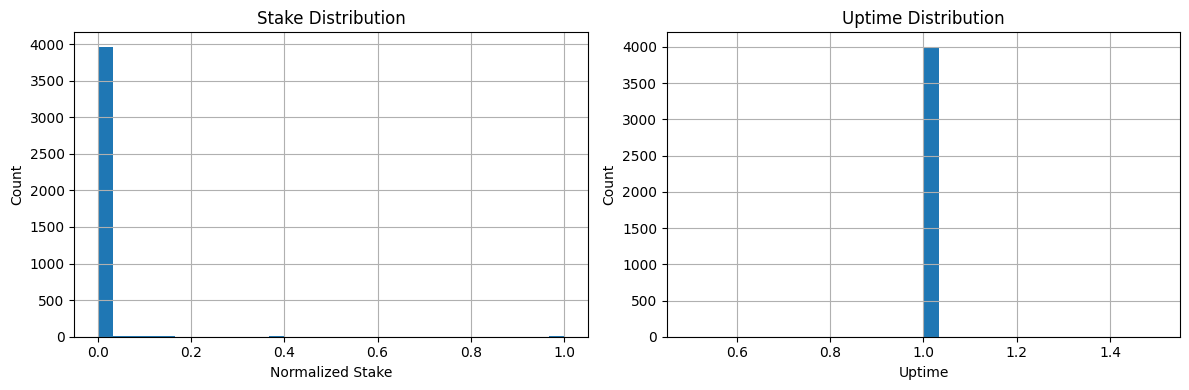

In [3]:
# --- Exploratory Data Analysis (EDA) ---

print('Shape of dataset:', df.shape)

print('Columns:', df.columns.tolist())

display(df.head())

print('\nSummary statistics:')

display(df.describe(include='all'))

print('\nMissing values per column:')

print(df.isnull().sum())

print('\nSlashed value counts:')

print(df['slashed'].value_counts())

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)

df['stake'].hist(bins=30)

plt.title('Stake Distribution')

plt.xlabel('Normalized Stake')

plt.ylabel('Count')

plt.subplot(1,2,2)

df['uptime'].hist(bins=30)

plt.title('Uptime Distribution')

plt.xlabel('Uptime')

plt.ylabel('Count')

plt.tight_layout()

plt.show()

In [4]:
# --- Environment Simulation ---

from dataclasses import dataclass

ACTIONS = {0: "propose", 1: "attest", 2: "abstain"}

@dataclass
class EnvState:
    uptime: float
    missed_att: int
    missed_prop: int
    slashed: bool
    stake: float

class PoSEnvironment:
    def __init__(self, config, aligned_df):
        self.config = config
        self.df = aligned_df.head(self.config.num_validators).reset_index(drop=True).copy()
        self.epoch = 0
        self._state = {}
        for _, row in self.df.iterrows():
            vid = int(row["validator_index"])
            self._state[vid] = EnvState(
                uptime=float(row["uptime"]),
                missed_att=int(row["missed_att"]),
                missed_prop=int(row["missed_prop"]),
                slashed=bool(row["slashed"]),
                stake=float(row["stake"]),
            )

    def list_validator_ids(self):
        return list(self._state.keys())

    def get_agent_state(self, validator_id):
        st = self._state[validator_id]
        uptime_bucket = min(4, int(st.uptime * 5))
        missed_att_bucket = min(4, st.missed_att // 10)
        missed_prop_bucket = min(4, st.missed_prop // 2)
        slashed_bit = 1 if st.slashed else 0
        return (uptime_bucket, missed_att_bucket, missed_prop_bucket, slashed_bit)

    def step_agent(self, validator_id, action):
        st = self._state[validator_id]
        name = ACTIONS.get(action, "abstain")
        noise = np.random.normal(0, 0.01)
        # Simulate action effects (simplified)
        if name == "propose":
            st.uptime = min(1.0, st.uptime + 0.01 + noise)
            st.missed_prop = max(0, st.missed_prop - 1)
        elif name == "attest":
            st.uptime = min(1.0, st.uptime + 0.005 + noise)
            st.missed_att = max(0, st.missed_att - 1)
        elif name == "abstain":
            st.uptime = max(0.0, st.uptime - 0.01 + noise)
            st.missed_att += 1
            st.missed_prop += 1
        # Random slashing event (rare)
        if np.random.rand() < 0.01:
            st.slashed = True
        # Reward shaping
        reward = st.uptime - 0.1 * (st.missed_att + st.missed_prop) - (1.0 if st.slashed else 0.0)
        info = {
            "uptime": st.uptime,
            "missed_att": st.missed_att,
            "missed_prop": st.missed_prop,
            "slashed": st.slashed
        }
        done = False
        next_state = self.get_agent_state(validator_id)
        return next_state, reward, done, info

    def get_state_frame(self):
        rows = []
        for vid, st in self._state.items():
            rows.append({
                "validator_id": vid,
                "uptime": st.uptime,
                "missed_att": st.missed_att,
                "missed_prop": st.missed_prop,
                "slashed": st.slashed,
                "stake": st.stake
            })
        return pd.DataFrame(rows)

In [5]:
# --- Agent Definition (Base & MARL) ---

from abc import ABC, abstractmethod

class BaseAgent(ABC):
    def __init__(self, agent_id):
        self.agent_id = agent_id
        self.state = None
        self.last_action = None

    @abstractmethod
    def observe_state(self, state):
        pass

    @abstractmethod
    def select_action(self):
        pass

    @abstractmethod
    def update(self, next_state, reward, done):
        pass

    @abstractmethod
    def update_trust_score(self, uptime, missed_blocks, slashed):
        pass

    def set_last_action(self, action):
        self.last_action = action

# Trust score update function
def update_trust(current_trust, uptime, missed_blocks, slashed):
    trust = current_trust
    if slashed:
        trust *= 0.5
    trust += 0.7 * uptime - 0.3 * (missed_blocks / 10.0)
    trust = max(0.0, min(1.0, trust))
    return trust

class MARLAgent(BaseAgent):
    def __init__(self, agent_id, config):
        super().__init__(agent_id)
        self.cfg = config
        self.trust = config.initial_trust
        self.q_table = defaultdict(lambda: np.zeros(config.action_space, dtype=float))
        self.learning_rate = config.learning_rate
        self.discount_factor = config.gamma
        self.epsilon = config.epsilon_start
        self.epsilon_min = config.epsilon_min
        self.epsilon_decay = config.epsilon_decay
        self.last_uptime = 0.0
        self.last_missed_blocks = 0
        self.last_slashed = False

    def observe_state(self, state):
        self.state = tuple(state)

    def select_action(self):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, self.cfg.action_space)
        else:
            action = int(np.argmax(self.q_table[self.state]))
        self.last_action = action
        return action

    def update(self, next_state, reward, done):
        next_state = tuple(next_state)
        best_next_q = float(np.max(self.q_table[next_state]))
        td_target = reward + self.discount_factor * best_next_q * (0.0 if done else 1.0)
        td_error = td_target - self.q_table[self.state][self.last_action]
        self.q_table[self.state][self.last_action] += self.learning_rate * td_error
        self.state = next_state

    def update_trust_score(self, uptime, missed_blocks, slashed):
        self.trust = update_trust(self.trust, uptime, missed_blocks, slashed)
        self.last_uptime = float(uptime)
        self.last_missed_blocks = int(missed_blocks)
        self.last_slashed = bool(slashed)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [6]:
# --- Training Loop ---

config = Config()
env = PoSEnvironment(config, df)
agents = [MARLAgent(agent_id=vid, config=config) for vid in env.list_validator_ids()]

log = []

for ep in range(config.num_epochs):
    trusts = []
    for a in agents:
        s = env.get_agent_state(a.agent_id)
        a.observe_state(s)
        action = a.select_action()
        s2, reward, done, info = env.step_agent(a.agent_id, action)
        a.update(s2, reward, done)
        missed_blocks = info["missed_att"] + info["missed_prop"]
        a.update_trust_score(info["uptime"], missed_blocks, info["slashed"])
        a.decay_epsilon()
        trusts.append(a.trust)
    avg_trust = sum(trusts) / len(trusts)
    log.append((ep+1, avg_trust))
    print(f"[Episode {ep+1}] Avg Trust = {avg_trust:.3f}")

# Save trust log as DataFrame
trust_log_df = pd.DataFrame(log, columns=["episode", "avg_trust"])

[Episode 1] Avg Trust = 0.999
[Episode 2] Avg Trust = 1.000
[Episode 3] Avg Trust = 1.000
[Episode 4] Avg Trust = 1.000
[Episode 5] Avg Trust = 1.000
[Episode 6] Avg Trust = 1.000
[Episode 7] Avg Trust = 1.000
[Episode 8] Avg Trust = 1.000
[Episode 9] Avg Trust = 1.000
[Episode 10] Avg Trust = 1.000


In [7]:
# --- Evaluation, Selection, and XAI ---

def select_top_validators(agents, k):
    agents_sorted = sorted(agents, key=lambda a: a.trust, reverse=True)
    return agents_sorted[:k]

def detect_malicious_agents(agents, threshold=0.2):
    return [a for a in agents if a.trust <= threshold]

def explain_selection(selected_agents):
    expl = {}
    for a in selected_agents:
        expl[a.agent_id] = {
            "trust_score": round(a.trust, 3),
            "uptime_pct": round(a.last_uptime * 100.0, 2),
            "missed_blocks": a.last_missed_blocks,
            "slashed": a.last_slashed,
        }
    return expl

# Select top validators and detect malicious ones
top_validators = select_top_validators(agents, k=10)
malicious_agents = detect_malicious_agents(agents)

# Explain selections
explanations = explain_selection(top_validators)

print("Top Validators (ID, Trust):", [(a.agent_id, round(a.trust,3)) for a in top_validators])
print("Malicious Agents (ID, Trust):", [(a.agent_id, round(a.trust,3)) for a in malicious_agents])
print("\nExplanations for Top Validators:")
for vid, expl in explanations.items():
    print(f"Validator {vid}: {expl}")

Top Validators (ID, Trust): [(12345, 1.0), (67890, 1.0), (424242, 1.0), (40000, 1.0), (40001, 1.0), (40002, 1.0), (40003, 1.0), (40004, 1.0), (40005, 1.0), (40006, 1.0)]
Malicious Agents (ID, Trust): []

Explanations for Top Validators:
Validator 12345: {'trust_score': 1.0, 'uptime_pct': 98.76, 'missed_blocks': 2, 'slashed': False}
Validator 67890: {'trust_score': 1.0, 'uptime_pct': 99.41, 'missed_blocks': 3, 'slashed': False}
Validator 424242: {'trust_score': 1.0, 'uptime_pct': 96.26, 'missed_blocks': 8, 'slashed': False}
Validator 40000: {'trust_score': 1.0, 'uptime_pct': 95.06, 'missed_blocks': 3, 'slashed': False}
Validator 40001: {'trust_score': 1.0, 'uptime_pct': 96.09, 'missed_blocks': 3, 'slashed': False}
Validator 40002: {'trust_score': 1.0, 'uptime_pct': 97.18, 'missed_blocks': 8, 'slashed': False}
Validator 40003: {'trust_score': 1.0, 'uptime_pct': 95.61, 'missed_blocks': 8, 'slashed': False}
Validator 40004: {'trust_score': 1.0, 'uptime_pct': 100.0, 'missed_blocks': 0, 'sla

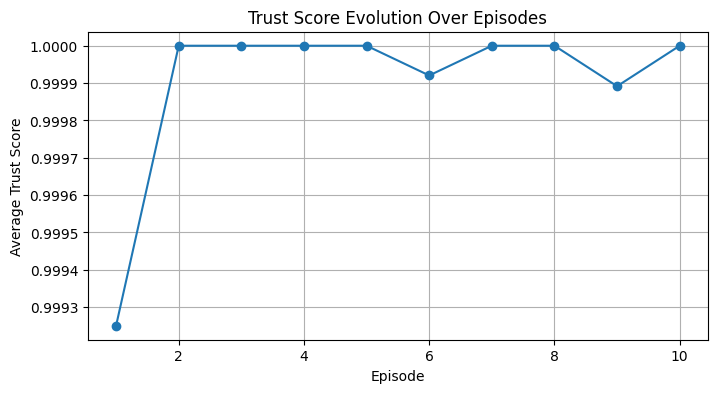

In [8]:
# --- Export & Visualization ---

# Export trust log and final state
os.makedirs(config.log_dir, exist_ok=True)
trust_log_df.to_csv(os.path.join(config.log_dir, "trust_metrics.csv"), index=False)
env.get_state_frame().to_csv(os.path.join(config.log_dir, "final_state.csv"), index=False)

# Plot trust score evolution
plt.figure(figsize=(8,4))
plt.plot(trust_log_df["episode"], trust_log_df["avg_trust"], marker='o')
plt.xlabel("Episode")
plt.ylabel("Average Trust Score")
plt.title("Trust Score Evolution Over Episodes")
plt.grid(True)
plt.show()